In [15]:
!pip install pandas
!pip install torch
!pip install torchvision
!pip install scikit-learn
!pip install matplotlib

  Using cached scipy-1.13.1-cp39-cp39-macosx_12_0_arm64.whl.metadata (60 kB)
  Using cached joblib-1.4.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached threadpoolctl-3.5.0-py3-none-any.whl.metadata (13 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 60.2 MB/s eta 0:00:0000:01
Using cached joblib-1.4.2-py3-none-any.whl (301 kB)
Using cached scipy-1.13.1-cp39-cp39-macosx_12_0_arm64.whl (30.3 MB)
Using cached threadpoolctl-3.5.0-py3-none-any.whl (18 kB)
  Using cached matplotlib-3.9.4-cp39-cp39-macosx_11_0_arm64.whl.metadata (11 kB)
  Using cached contourpy-1.3.0-cp39-cp39-macosx_11_0_arm64.whl.metadata (5.4 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.55.3-cp39-cp39-macosx_10_9_universal2.whl.metadata (165 kB)
  Using cached kiwisolver-1.4.7-cp39-cp39-macosx_11_0_arm64.whl.metadata (6.3 kB)
  Using cached pyparsing-3.2.1-py3-none-any.whl.metadata (5.0 kB)
  Using cached importlib_resources-6.5.2-py3-none-any.whl.metadata (

In [1]:
import pandas as pd
import torch
import torchvision
import torchvision.transforms as transforms
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import cv2
import os
import numpy as np

In [20]:
# Import the dataset 

df = pd.read_csv('/Users/marlon/Desktop/sem/vs/vs_proj/VCS_Project/digit_char_dataset.csv').astype('float32')

df.head()

# Notice that A-Z is represented by 10-35 and 0-9 is represented by 0-9

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784,class
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0


In [21]:
# Define the features and the target
X = df.drop('class',axis = 1)
y = df['class']

In [55]:
# First check if the pixels are already normalized
assert X.iloc[1,:].max() <= 1, "The pixels are not normalized"

AssertionError: The pixels are not normalized

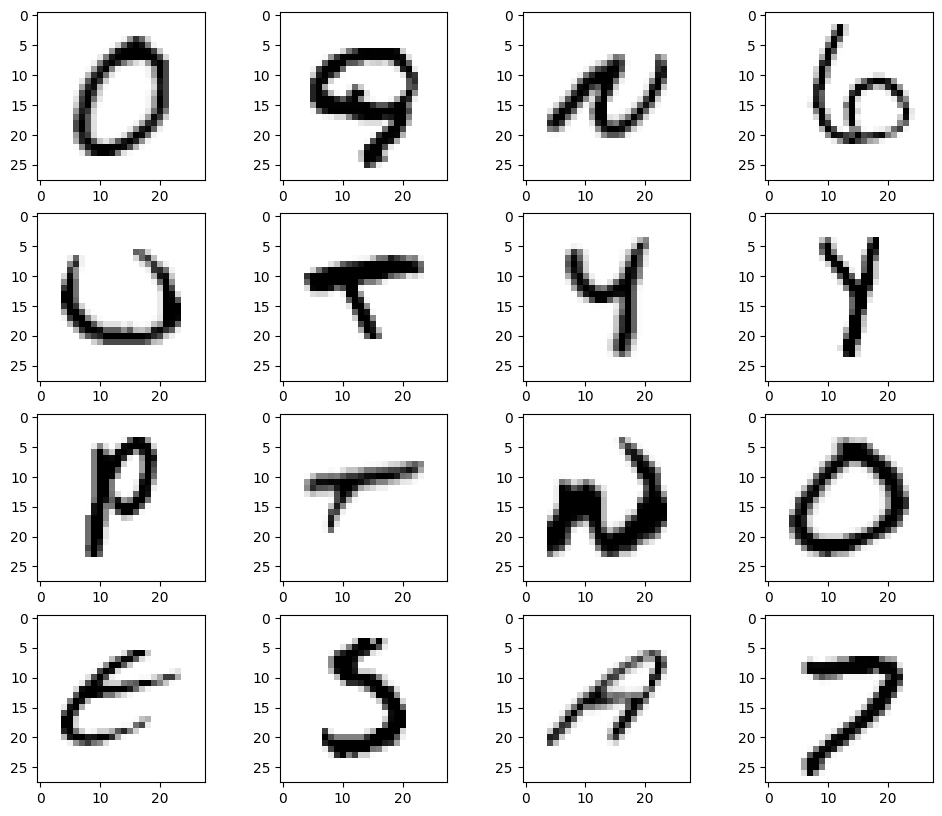

In [35]:
# Plot some examples
X_shuffle = shuffle(X)

plt.figure(figsize = (12,10))
row, colums = 4, 4
for i in range(16):  
    plt.subplot(colums, row, i+1)
    plt.imshow(X_shuffle.iloc[i].values.reshape(28,28),interpolation='nearest', cmap='Greys')
plt.show()

In [41]:
# Convert to tensors
X = torch.tensor(X.values)
# Reshape the data to (n_samples, height,width) (channels = 1 since we have only black and white images)
X = X.reshape(-1,1, 28, 28)
y = torch.tensor(y.values).type(torch.long) # labels are integers

print(f"Our data has shape {X.shape} and the labels have shape {y.shape}")

Our data has shape torch.Size([442450, 1, 28, 28]) and the labels have shape torch.Size([442450])


In [42]:
# Split the data into train,validation and test 


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)


In [43]:
# Create PyTorch dataset
class CharactersDataset(Dataset):
    def __init__(self, data, labels, transform=None, target_transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.data[idx, :,:]
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label



In [44]:
# Define the transformations (normalization)
transform =  transforms.Normalize(mean=(0.5), std=(0.5)) # Normalize the pixels to [-1, 1]

In [45]:
# Create the dataset
dataset_train = CharactersDataset(X_train, y_train, transform=transform)
dataset_val = CharactersDataset(X_val, y_val, transform=transform)
dataset_test = CharactersDataset(X_test, y_test, transform=transform)


In [46]:
dataloader_train = DataLoader(dataset_train, batch_size=64, shuffle=True)
dataloader_val = DataLoader(dataset_val, batch_size=64, shuffle=True)
dataloader_test = DataLoader(dataset_test, batch_size=64, shuffle=True)

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


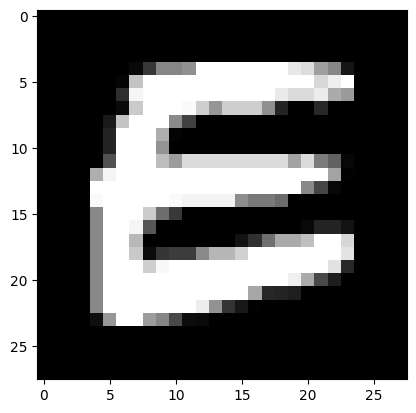

Label: 14


In [51]:
train_features, train_labels = next(iter(dataloader_train))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

In [4]:
# Define the actual CNN network 
# We will use 3 convolutional layers, 1 pooling layer and 2 fully connected layers

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 36) # 36 classes

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [122]:
net = Net()

In [123]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [124]:
# Set model to train mode at the start of training
net.train()

for epoch in range(10):  # loop over the dataset multiple times
    # Training phase
    running_loss = 0.0
    for i, data in enumerate(dataloader_train, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] training loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

    # Validation phase
    net.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():  # Disable gradient computation
        for data in dataloader_val:
            inputs, labels = data
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    avg_val_loss = val_loss / len(dataloader_val)
    accuracy = 100 * correct / total
    print(f'Epoch {epoch + 1} Validation Loss: {avg_val_loss:.3f}, Accuracy: {accuracy:.2f}%')
    
    net.train()  # Set the model back to training mode

print('Finished Training')

[1,  2000] training loss: 0.457
[1,  4000] training loss: 0.198
Epoch 1 Validation Loss: 0.168, Accuracy: 95.06%
[2,  2000] training loss: 0.154
[2,  4000] training loss: 0.145
Epoch 2 Validation Loss: 0.147, Accuracy: 95.75%
[3,  2000] training loss: 0.126
[3,  4000] training loss: 0.120
Epoch 3 Validation Loss: 0.125, Accuracy: 96.39%
[4,  2000] training loss: 0.106
[4,  4000] training loss: 0.108
Epoch 4 Validation Loss: 0.117, Accuracy: 96.67%
[5,  2000] training loss: 0.095
[5,  4000] training loss: 0.099
Epoch 5 Validation Loss: 0.112, Accuracy: 96.76%
[6,  2000] training loss: 0.090
[6,  4000] training loss: 0.090
Epoch 6 Validation Loss: 0.106, Accuracy: 96.89%
[7,  2000] training loss: 0.082
[7,  4000] training loss: 0.084
Epoch 7 Validation Loss: 0.109, Accuracy: 96.94%
[8,  2000] training loss: 0.076
[8,  4000] training loss: 0.080
Epoch 8 Validation Loss: 0.109, Accuracy: 96.92%
[9,  2000] training loss: 0.073
[9,  4000] training loss: 0.076
Epoch 9 Validation Loss: 0.100, 

In [125]:
PATH = '/Users/marlon/Desktop/sem/vs/vs_proj/VCS_Project/character_classification_CNN_model/network.pth'
torch.save(net.state_dict(), PATH)

In [126]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in dataloader_test:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the test images: {100 * correct // total} %')

Accuracy of the network on the test images: 97 %


In [127]:
# prepare to count predictions for each class

# Classes range from 0 to 35
classes = list(range(36))

# Replace numbers 10-35 with A-Z
classes = [str(i) if i < 10 else chr(i+55) for i in classes]

correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in dataloader_test:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname} is {accuracy:.1f} %')

# We see that class 0 (i.e. digit 0) has the biggest problems

Accuracy for class: 0 is 71.4 %
Accuracy for class: 1 is 98.1 %
Accuracy for class: 2 is 90.9 %
Accuracy for class: 3 is 97.4 %
Accuracy for class: 4 is 95.8 %
Accuracy for class: 5 is 91.1 %
Accuracy for class: 6 is 98.0 %
Accuracy for class: 7 is 99.4 %
Accuracy for class: 8 is 93.6 %
Accuracy for class: 9 is 94.7 %
Accuracy for class: A is 98.9 %
Accuracy for class: B is 96.7 %
Accuracy for class: C is 98.9 %
Accuracy for class: D is 95.1 %
Accuracy for class: E is 99.0 %
Accuracy for class: F is 93.6 %
Accuracy for class: G is 94.5 %
Accuracy for class: H is 94.8 %
Accuracy for class: I is 97.3 %
Accuracy for class: J is 97.6 %
Accuracy for class: K is 97.1 %
Accuracy for class: L is 98.0 %
Accuracy for class: M is 97.4 %
Accuracy for class: N is 99.3 %
Accuracy for class: O is 97.9 %
Accuracy for class: P is 98.5 %
Accuracy for class: Q is 95.5 %
Accuracy for class: R is 96.4 %
Accuracy for class: S is 99.0 %
Accuracy for class: T is 99.3 %
Accuracy for class: U is 97.5 %
Accuracy

In [38]:
# Prepare characters from license plates for prediction

def prepare_input(img_path):
    #https://en.wikipedia.org/wiki/MNIST_database
    #The original dataset from MNIST contained 128x128 binary images.
    #Each was size-normalized to fit in a 20x20 pixel box while preserving their aspect ratio, and anti-aliased to grayscale. 
    # Then it was put into a 28x28 image by translating it until the center of mass of the pixels is in the center of the image
    # TODO : MIST white digits black background or reversed ?? 
    """ Prepare images following the exact MNIST preparation process """
    counter = 0
    all_imgs = []
    for img in os.listdir(FOLDER_PATH):
        img_path = os.path.join(FOLDER_PATH, img)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        
        # 0. First resize to 128x128 to match original MNIST process
        img = cv2.resize(img, (128, 128))
        
        # 1. Invert black & white (ensure digits are white on black background)
    #    img = cv2.bitwise_not(img)
        
        # 2. Apply anti-aliasing (important MNIST preprocessing step)
        img = cv2.GaussianBlur(img, (3,3), 0)
        
        # 3. Fit into 20x20 box while preserving aspect ratio
        height, width = img.shape
        aspect_ratio = width / height
        
        if aspect_ratio > 1:
            # Width is larger, scale to 20 width
            new_width = 20
            new_height = int(20 / aspect_ratio)
        else:
            # Height is larger, scale to 20 height
            new_height = 20
            new_width = int(20 * aspect_ratio)
            
        img = cv2.resize(img, (new_width, new_height))
        
        # 4. Create 28x28 black canvas (MNIST uses white digits on black background)
        canvas = np.zeros((28, 28), dtype=np.uint8)
        canvas.fill(0) # 255
        
        # 5. Calculate position to paste the 20x20 image
        x_offset = (28 - new_width) // 2
        y_offset = (28 - new_height) // 2
        
        # 6. Place the image in the center of the canvas
        canvas[y_offset:y_offset+new_height, x_offset:x_offset+new_width] = img
        
        # 7. Center using center of mass
        M = cv2.moments(canvas)
        if M["m00"] != 0:
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
        else:
            cX, cY = 14, 14  # Half of 28

        # Calculate the shift needed
        deltaX = 14 - cX  
        deltaY = 14 - cY
        
        # Create translation matrix
        T = np.float32([[1, 0, deltaX], [0, 1, deltaY]])
        
        # Apply translation (use black borderValue since MNIST uses white background)
        img = cv2.warpAffine(canvas, T, (28, 28), borderValue=0) # 255
        
        # 8. Normalize pixel values to [0, 1] before saving
        img = img.astype(np.float32) / 255.0
        
        # Save normalized image (multiply by 255 and convert to uint8 for saving)
        save_img = (img * 255).astype(np.uint8)
        cv2.imwrite(f'/Users/marlon/Desktop/sem/vs/vs_proj/VCS_Project/results/license_plates/prepared_for_CNN/license_plate.1/character_{counter}.png', save_img)
        counter += 1
        all_imgs.append(img)  # append the normalized [0,1] version
    
    # Convert to tensor (no need to divide by 255 since we already normalized)
    all_imgs = torch.tensor(all_imgs).type(torch.float32)
    all_imgs = all_imgs.reshape(-1, 1, 28, 28)
    
    # Normalize to [-1, 1]
    all_imgs = transforms.Normalize(mean=(0.5,), std=(0.5,))(all_imgs)
    
    return all_imgs






The shape of the characters is torch.Size([7, 1, 28, 28])
tensor([11, 10, 33,  5, 10, 11,  5])
Predicted: B


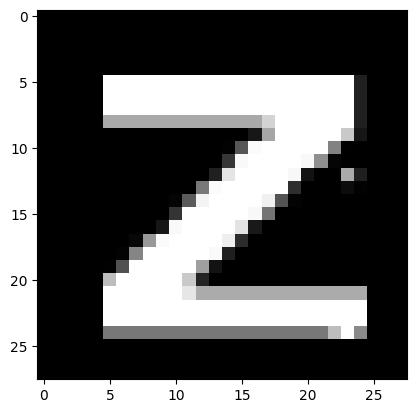

Predicted: A


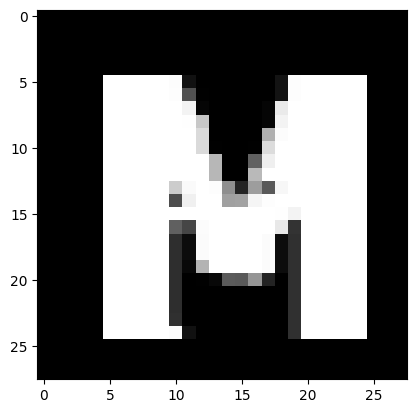

Predicted: X


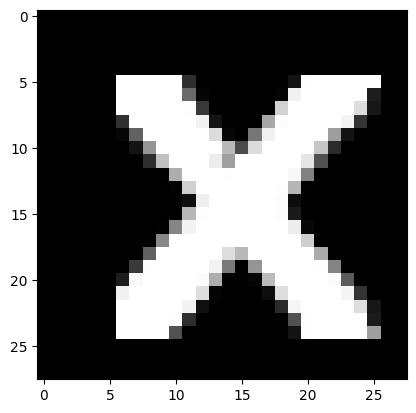

Predicted: 5


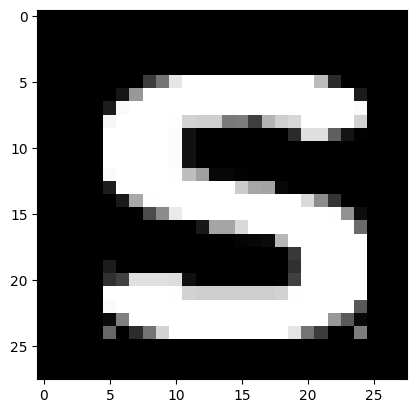

Predicted: A


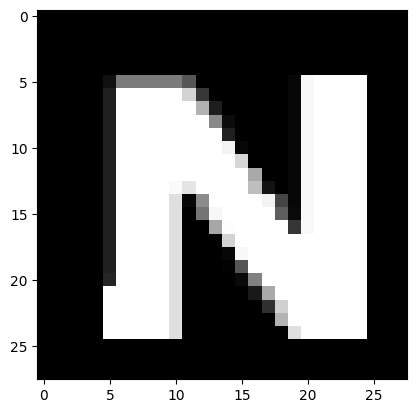

Predicted: B


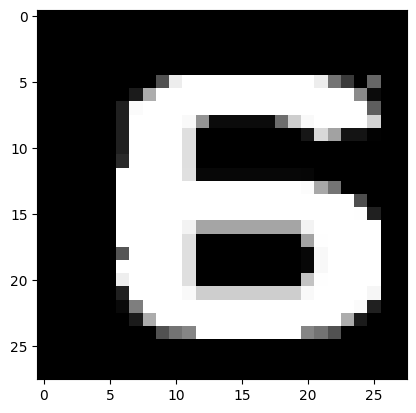

Predicted: 5


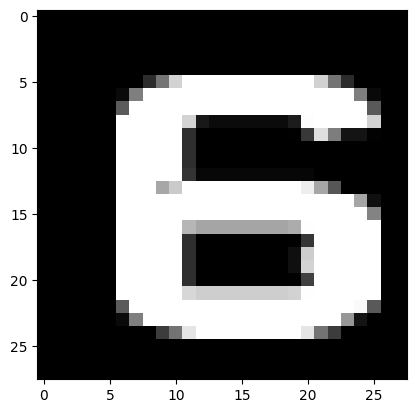

In [39]:
# path where segmented characters are stored
FOLDER_PATH = '/Users/marlon/Desktop/sem/vs/vs_proj/VCS_Project/results/license_plates/segmented_plate.1'
MODEL_PATH = '/Users/marlon/Desktop/sem/vs/vs_proj/VCS_Project/character_classification_CNN_model/network.pth'

# Get the prepared input of characters
characters = prepare_input(FOLDER_PATH)

print(f'The shape of the characters is {characters.shape}')

# Load the model
net = Net()
net.load_state_dict(torch.load(MODEL_PATH, weights_only=True))

# Make predictions
net.eval()
with torch.no_grad():
    predictions = net(characters)
    _, predicted = torch.max(predictions, 1)

print(predicted)

# Print predictions and show the original images
for i in range(len(characters)):
    predicted_class = predicted[i] if predicted[i] < 10 else chr(predicted[i] + 55)
    print(f'Predicted: {predicted_class}')
    plt.imshow(characters[i].squeeze(), cmap='gray')
    plt.show()


# TODO : when we don't invert colours (i.e black background, white front) we get better results, but MNIST is black letter, white background, so unsure what goes wrong....

# TODO :

#https://stackoverflow.com/questions/27925358/pre-processing-before-digit-recognition-for-nn-cnn-trained-with-mnist-dataset 
# 1. preprocess MNIST pictures again somehow so we can match them closer to our actual inputs
# Create a larger dataset with license plate characters, but will be hard since the MNIST + A-Z dataset is huge ... 
